# 1. Load libraries and data

In [1]:
import networkx as nx

import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import collections
from community import community_louvain
from networkx.algorithms.community.centrality import girvan_newman
from sklearn.preprocessing import MinMaxScaler
import itertools
%matplotlib inline

import helper

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_trade = helper.clean_trade_quantities(pd.read_pickle("../data/df_trade.pkl"))

In [3]:
df_trade

,Importer,Exporter,Item,1993,1994,1995,1996,1997,1998,1999,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,Argentina,Maize,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,Azerbaijan,Tea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,Afghanistan,Azerbaijan,Wheat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,Bangladesh,Jute,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,26.0,111.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,Belgium,Cotton lint,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446420,Yemen,Zimbabwe,Maize,0.0,0.0,0.0,27007.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446421,Zambia,Zimbabwe,Papayas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
446422,Zambia,Zimbabwe,Plantains and others,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,95.0,0.0
446423,Zambia,Zimbabwe,"Pumpkins, squash and gourds",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_pop = pd.read_csv("../data/worldbank_pop_data.csv", skiprows=4)
drop_columns = ['Country Code', 'Indicator Name', 'Indicator Code', '2019', '2018', '2017', 'Unnamed: 64'] + \
                [str(year) for year in range(1960, 1993)]
df_pop = df_pop.drop(columns=drop_columns)
df_pop = df_pop.rename(columns={'Country Name': 'Country'})
df_pop.reset_index(drop=True,inplace=True)
df_pop = df_pop.set_index(['Country'])

In [5]:
df_pop

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Country,,,,,,,,,,,,,,,,,,,,,
Aruba,72504.0,76700.0,80324.0,83200.0,85451.0,87277.0,89005.0,90853.0,92898.0,94992.0,...,101222.0,101358.0,101455.0,101669.0,102046.0,102560.0,103159.0,103774.0,104341.0,104872.0
Afghanistan,15816603.0,17075727.0,18110657.0,18853437.0,19357126.0,19737765.0,20170844.0,20779953.0,21606988.0,22600770.0,...,27100536.0,27722276.0,28394813.0,29185507.0,30117413.0,31161376.0,32269589.0,33370794.0,34413603.0,35383128.0
Angola,13075049.0,13503747.0,13945206.0,14400719.0,14871570.0,15359601.0,15866869.0,16395473.0,16945753.0,17519417.0,...,20905363.0,21695634.0,22514281.0,23356246.0,24220661.0,25107931.0,26015780.0,26941779.0,27884381.0,28842484.0
Albania,3227287.0,3207536.0,3187784.0,3168033.0,3148281.0,3128530.0,3108778.0,3089027.0,3060173.0,3051010.0,...,2970017.0,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0
Andorra,60971.0,62677.0,63850.0,64360.0,64327.0,64142.0,64370.0,65390.0,67341.0,70049.0,...,82684.0,83862.0,84463.0,84449.0,83747.0,82427.0,80774.0,79213.0,78011.0,77297.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,1965000.0,1997000.0,2029000.0,2059000.0,2086000.0,1966000.0,1762000.0,1700000.0,1701154.0,1702310.0,...,1733404.0,1747383.0,1761474.0,1775680.0,1791000.0,1805200.0,1824100.0,1821800.0,1801800.0,1816200.0
"Yemen, Rep.",13634076.0,14297613.0,14913315.0,15469274.0,15975668.0,16450310.0,16921149.0,17409072.0,17918373.0,18443691.0,...,21282515.0,21892146.0,22516460.0,23154855.0,23807588.0,24473178.0,25147109.0,25823485.0,26497889.0,27168210.0
South Africa,39633750.0,40564059.0,41435758.0,42241011.0,42987461.0,43682260.0,44338543.0,44967708.0,45571274.0,46150913.0,...,49119759.0,49779471.0,50477011.0,51216964.0,52004172.0,52834005.0,53689236.0,54545991.0,55386367.0,56203654.0


In [6]:
df_gdp = pd.read_csv("../data/worldbank_gdp_data.csv", skiprows=4)
df_gdp = df_gdp.drop(columns=drop_columns)
df_gdp = df_gdp.rename(columns={'Country Name': 'Country'})
df_gdp.reset_index(drop=True,inplace=True)
df_gdp = df_gdp.set_index(['Country'])
df_gdp = df_gdp.interpolate(method='linear', limit_direction='both')

In [7]:
df_gdp

,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
Country,,,,,,,,,,,,,,,,,,,,,
Aruba,1.082980e+09,1.245688e+09,1.320475e+09,1.379961e+09,1.531944e+09,1.665101e+09,1.722799e+09,1.873453e+09,1.920112e+09,1.941341e+09,...,2.615084e+09,2.745251e+09,2.498883e+09,2.390503e+09,2.549721e+09,2.534637e+09,2.581564e+09,2.649721e+09,2.691620e+09,2.646927e+09
Afghanistan,3.425850e+09,2.842005e+09,3.429612e+09,4.453204e+09,4.590161e+09,4.085665e+09,3.937861e+09,5.501524e+09,5.428088e+09,4.055177e+09,...,9.747886e+09,1.010922e+10,1.243909e+10,1.585657e+10,1.780428e+10,2.000162e+10,2.056105e+10,2.048487e+10,1.990711e+10,1.936264e+10
Angola,5.768720e+09,4.438321e+09,5.538749e+09,7.526447e+09,7.648377e+09,6.506230e+09,6.152923e+09,9.129595e+09,8.936064e+09,1.528559e+10,...,6.526645e+10,8.853861e+10,7.030716e+10,8.379950e+10,1.117897e+11,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11
Albania,1.185315e+09,1.880952e+09,2.392765e+09,3.199643e+09,2.258516e+09,2.545967e+09,3.212119e+09,3.480355e+09,3.922099e+09,4.348070e+09,...,1.067732e+10,1.288135e+10,1.204421e+10,1.192695e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322825e+10,1.138693e+10,1.186135e+10
Andorra,1.007026e+09,1.017549e+09,1.178739e+09,1.223945e+09,1.180597e+09,1.211932e+09,1.239876e+09,1.434430e+09,1.496913e+09,1.733117e+09,...,4.016972e+09,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Kosovo,2.750697e+09,2.194227e+09,2.241827e+09,3.017797e+09,3.562016e+09,3.297312e+09,3.949968e+09,1.849196e+09,2.535334e+09,2.406271e+09,...,4.655899e+09,5.687418e+09,5.653793e+09,5.830464e+09,6.691827e+09,6.499936e+09,7.071960e+09,7.386891e+09,6.440612e+09,6.714712e+09
"Yemen, Rep.",5.368271e+09,4.167356e+09,4.258789e+09,5.785685e+09,6.838557e+09,6.325142e+09,7.641103e+09,9.652436e+09,9.861560e+09,1.069463e+10,...,2.165053e+10,2.691085e+10,2.513027e+10,3.090675e+10,3.272642e+10,3.540134e+10,4.041523e+10,4.322859e+10,4.262833e+10,3.096824e+10
South Africa,1.343081e+11,1.397525e+11,1.554609e+11,1.476063e+11,1.525874e+11,1.377748e+11,1.366323e+11,1.363613e+11,1.215149e+11,1.154819e+11,...,2.994170e+11,2.867690e+11,2.959374e+11,3.753483e+11,4.164170e+11,3.963294e+11,3.666449e+11,3.506376e+11,3.174156e+11,2.963409e+11


In [8]:
country_groups = pd.read_csv('../data/FAOSTAT_data_11-19-2019.csv')

In [9]:
country_groups

,Country Group Code,Country Group,Country Code,Country,M49 Code,ISO2 Code,ISO3 Code
0,5100,Africa,4,Algeria,12.0,DZ,DZA
1,5100,Africa,7,Angola,24.0,AO,AGO
2,5100,Africa,53,Benin,204.0,BJ,BEN
3,5100,Africa,20,Botswana,72.0,BW,BWA
4,5100,Africa,24,British Indian Ocean Territory,86.0,IO,IOT
...,...,...,...,...,...,...,...
1848,5000,World,246,Yemen Ar Rp,886.0,NaN,NaN
1849,5000,World,247,Yemen Dem,720.0,NaN,NaN
1850,5000,World,248,Yugoslav SFR,890.0,NaN,NaN
1851,5000,World,251,Zambia,894.0,ZM,ZMB


# 2. Graphs

## 2.1 Helper functions

In [10]:
def describe_graph(G):
    print(nx.info(G))
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [42]:
# Helper function for visualizing the graph
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o', width=1.0, node_size=50):
    plt.figure(figsize=(13,13)) 
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_size=node_size, node_color='#9abecf', node_shape=node_shape)
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha, width=width)
    plt.axis('off')

In [12]:
def replace_country(country, replacements, replacements_names):
    for i, replacement in enumerate(replacements):
        if country in replacement:
            return replacements_names[i]

In [13]:
def region_continent_pipeline(replacements, replacements_names, directed=False):
    df_trade_grouped = df_trade_unweighted.copy()

    for i, row in df_trade_grouped.iterrows():
        row.Exporter = replace_country(row['Exporter'], replacements, replacements_names)
        row.Importer = replace_country(row['Importer'], replacements, replacements_names)

    df_trade_grouped = df_trade_grouped.groupby(['Exporter', 'Importer']) \
                                                                   .size() \
                                                                   .to_frame('Count') \
                                                                   .reset_index()
    nx_grouped = nx.from_pandas_edgelist(df_trade_grouped, 'Exporter', 'Importer', \
                                                       edge_attr='Count', create_using=nx.DiGraph() if directed \
                                                                                    else nx.Graph())
    
    max_counts = np.max(df_trade_grouped['Count'].values)
    counts = [nx_grouped[u][v]['Count']/max_counts for u,v in nx_grouped.edges()]
    
    if directed:
        print(nx.info(nx_grouped))
    else:
        describe_graph(nx_grouped)
    
    visualize_graph(nx_grouped, with_labels=True, k=0.05, alpha=0.8, width=counts)
    
    return df_trade_grouped, nx_grouped

In [14]:
def check_connectedness(nx_graph):
    print(nx.is_connected(nx_graph))
    comp = list(nx.connected_components(nx_graph))
    print('The graph contains', len(comp), 'connected components')
    largest_comp = max(comp, key=len)
    percentage_lcc = len(largest_comp)/nx_graph.number_of_nodes() * 100
    print('The largest component has', len(largest_comp), 'nodes', 'accounting for %.2f'% percentage_lcc, '% of the nodes')

In [15]:
def rank_degree_undirected(nx_graph):
    degrees = dict(nx_graph.degree(nx_graph.nodes()))
    sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
    for node, degree in sorted_degree:
        print(node, 'has connection with', degree, 'other nodes.')

In [16]:
def rank_degree_directed(nx_graph):
    in_degrees = dict(nx_graph.in_degree(nx_graph.nodes()))
    sorted_in_degree = sorted(in_degrees.items(), key=itemgetter(1), reverse=True)
    out_degrees = dict(nx_graph.out_degree(nx_graph.nodes()))
    sorted__out_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
    for node, degree in sorted_degree:
        print(node, "has in-degree of", degree)
    for node, degree in sorted_degree:
        print(node, "has out-degree of", degree)

In [17]:
def region_continent_weighted_pipeline(replacements, replacements_names, year, df_pop, df_trade_grouped_weighted, directed=False):
    df_trade_grouped_weighted_filtered = df_trade_grouped_weighted[['Exporter', 'Importer', year]]
    
    nx_grouped_weighted = nx.from_pandas_edgelist(df_trade_grouped_weighted_filtered, 'Exporter', 'Importer', \
                                         edge_attr=year, create_using=nx.DiGraph() if directed else nx.Graph())
    
    scaler = MinMaxScaler((0,2))
    counts = scaler.fit_transform(np.array([nx_grouped_weighted[u][v][year] for u,v in nx_grouped_weighted.edges()]).reshape(-1,1)).reshape(-1)
    scaler = MinMaxScaler((50,10000))
    node_sizes = scaler.fit_transform((df_pop[year].values).reshape(-1,1)).reshape(-1)
    print(node_sizes)
    
    if directed:
        print(nx.info(nx_grouped_weighted))
    else:
        describe_graph(nx_grouped_weighted)
    
    visualize_graph(nx_grouped_weighted, with_labels=True, k=0.05, alpha=0.8, width=counts, node_size=node_sizes)
    
    return nx_grouped_weighted

## 2.2 Network graphs that don't take into account traded quantities

### 2.2.1 Global

In [18]:
df_trade_unweighted = df_trade[['Importer', 'Exporter']].drop_duplicates()

In [19]:
nx_unweighted = nx.from_pandas_edgelist(df_trade_unweighted, 'Exporter', 'Importer', edge_attr=None, create_using= nx.Graph())

In [20]:
describe_graph(nx_unweighted)

Name: 
Type: Graph
Number of nodes: 213
Number of edges: 14863
Average degree: 139.5587
Avg. Shortest Path Length: 1.3456
Diameter: 2.0000
Sparsity: 0.6583
Global clustering coefficient aka Transitivity: 0.7949


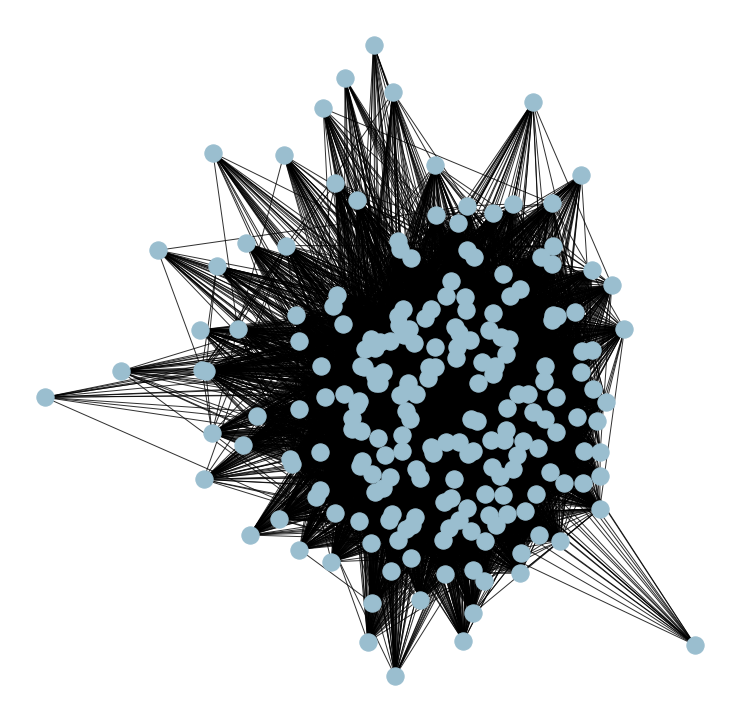

In [21]:
visualize_graph(nx_unweighted, with_labels=False, k=0.05, alpha=0.8)

We can see that the graph is not really understandable because of all the edges. Indeed, the average degree of a node is 139.5 so, on average, every country trades with almost 140 other countries. Therefore, we're going to focus our analysis on continents and regions instead.

### 2.2.2 Continents

In [22]:
african_countries = set(country_groups[country_groups['Country Group'] == 'Africa']['Country'])
american_countries = set(country_groups[country_groups['Country Group'] == 'Americas']['Country'])
asian_countries = set(country_groups[country_groups['Country Group'] == 'Asia']['Country'])
european_countries = set(country_groups[country_groups['Country Group'] == 'Europe']['Country'])
oceanian_countries = set(country_groups[country_groups['Country Group'] == 'Oceania']['Country'])

continents = [african_countries, american_countries, asian_countries, european_countries, oceanian_countries]
continent_names = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']

Name: 
Type: Graph
Number of nodes: 5
Number of edges: 15
Average degree:   6.0000
Avg. Shortest Path Length: 1.0000
Diameter: 1.0000
Sparsity: 1.5000
Global clustering coefficient aka Transitivity: 1.0000


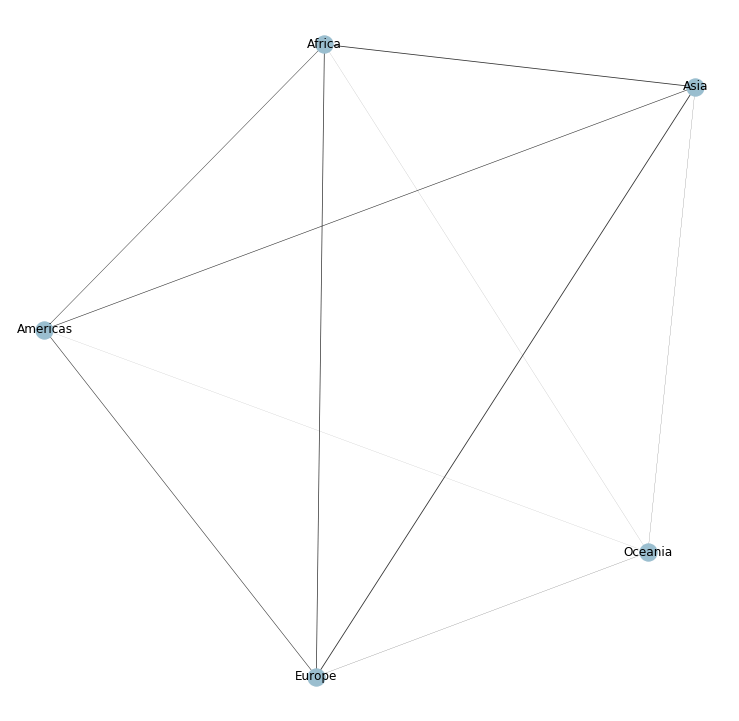

In [23]:
df_trade_continents, nx_undirected_continents = region_continent_pipeline(continents, continent_names)

In [24]:
check_connectedness(nx_undirected_continents)

True
The graph contains 1 connected components
The largest component has 5 nodes accounting for 100.00 % of the nodes


Name: 
Type: DiGraph
Number of nodes: 5
Number of edges: 25
Average in degree:   5.0000
Average out degree:   5.0000


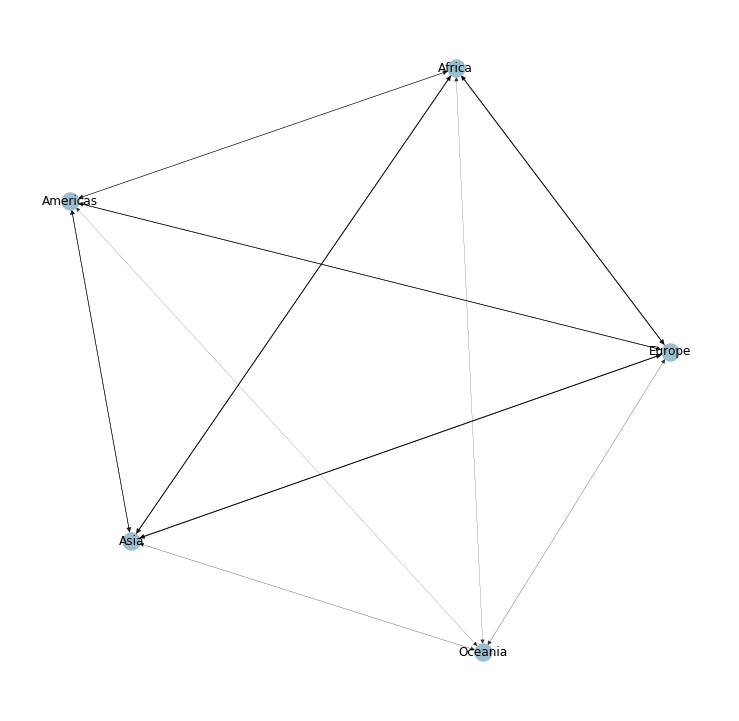

In [25]:
df_trade_continents, nx_directed_continents = region_continent_pipeline(continents, continent_names, directed=True)

### 2.2.3 Regions

In [26]:
region_names = ['Eastern Africa', 'Middle Africa', 'Northern Africa', 'Southern Africa', 'Western Africa',
                'Northern America', 'Central America', 'Caribbean', 'South America',
                'Central Asia', 'Eastern Asia', 'Southern Asia', 'South-Eastern Asia', 'Western Asia',
                'Eastern Europe', 'Northern Europe', 'Southern Europe', 'Western Europe',
                'Australia and New Zealand', 'Melanesia', 'Polynesia']
regions = [set(country_groups[country_groups['Country Group'] == region]['Country']) for region in region_names]

Name: 
Type: Graph
Number of nodes: 21
Number of edges: 231
Average degree:  22.0000
Avg. Shortest Path Length: 1.0000
Diameter: 1.0000
Sparsity: 1.1000
Global clustering coefficient aka Transitivity: 1.0000


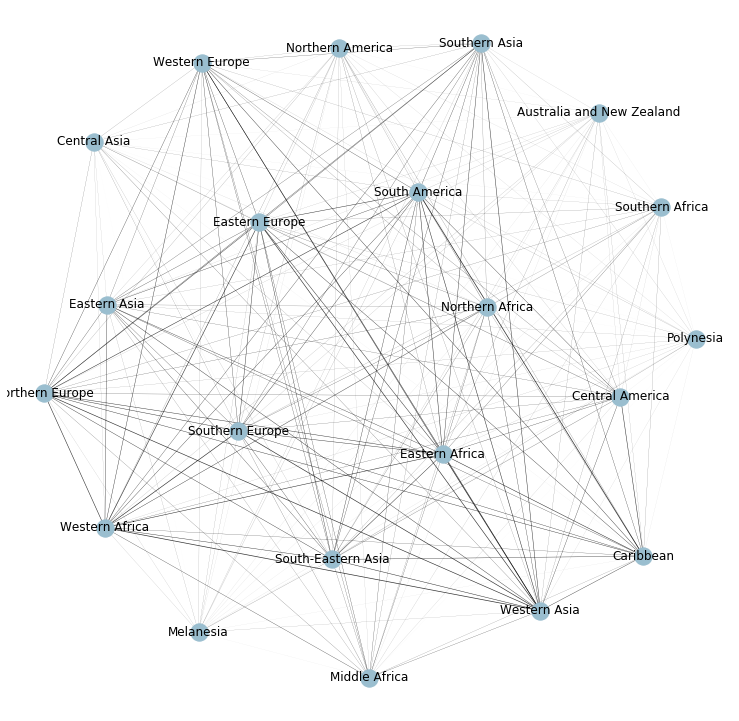

In [27]:
df_trade_regions, nx_undirected_regions = region_continent_pipeline(regions, region_names)

In [28]:
check_connectedness(nx_undirected_regions)

True
The graph contains 1 connected components
The largest component has 21 nodes accounting for 100.00 % of the nodes


Name: 
Type: DiGraph
Number of nodes: 21
Number of edges: 441
Average in degree:  21.0000
Average out degree:  21.0000


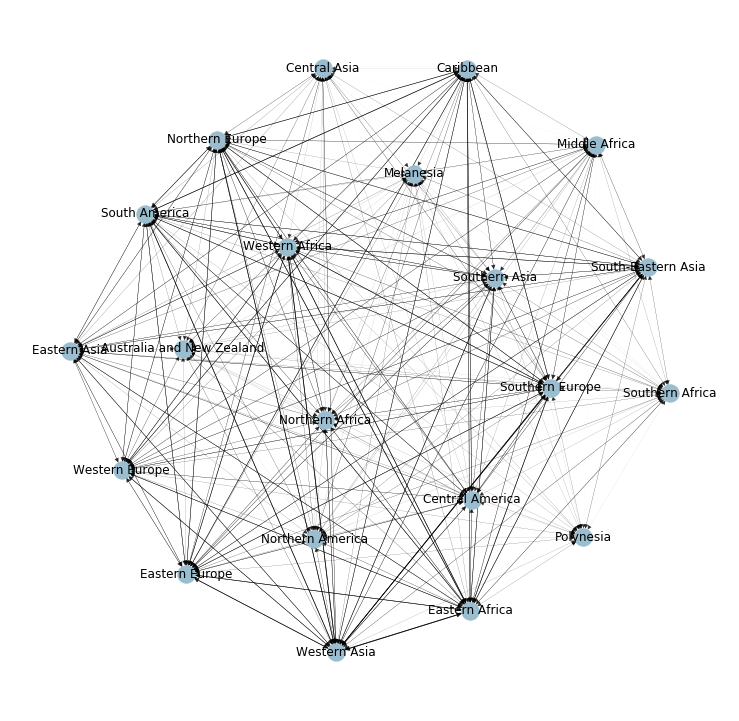

In [29]:
df_trade_regions, nx_directed_regions = region_continent_pipeline(regions, region_names, directed=True)

In [30]:
nx_directed_regions.number_of_selfloops()

21

## 2.3 Network graphs with traded quantities

### 2.3.1 Continents

In [31]:
df_pop_continent = df_pop.copy()
for i, row in df_pop_continent.iterrows():
    df_pop_continent.loc[i, 'Continent'] = replace_country(i, continents, continent_names)
df_pop_continent = df_pop_continent.groupby(['Continent']).sum().sort_index()

In [32]:
df_gdp_continent = df_gdp.copy()
for i, row in df_gdp_continent.iterrows():
    df_gdp_continent.loc[i, 'Continent'] = replace_country(i, continents, continent_names)
df_gdp_continent = df_gdp_continent.groupby(['Continent']).sum().sort_index()

In [33]:
df_trade_continent_weighted = df_trade.copy()
df_trade_continent_weighted = df_trade_continent_weighted.groupby(['Exporter', 'Importer']).sum().reset_index()

for i, row in df_trade_continent_weighted.iterrows():
    df_trade_continent_weighted.loc[i, 'Exporter'] = replace_country(row['Exporter'], continents, continent_names)
    df_trade_continent_weighted.loc[i, 'Importer'] = replace_country(row['Importer'], continents, continent_names)

df_trade_continent_weighted = df_trade_continent_weighted.groupby(['Exporter', 'Importer']) \
                                                       .sum() \
                                                       .reset_index()

[ 3364.41841726  2205.56353306 10000.          2604.20983615
    50.        ]
Name: 
Type: DiGraph
Number of nodes: 5
Number of edges: 25
Average in degree:   5.0000
Average out degree:   5.0000


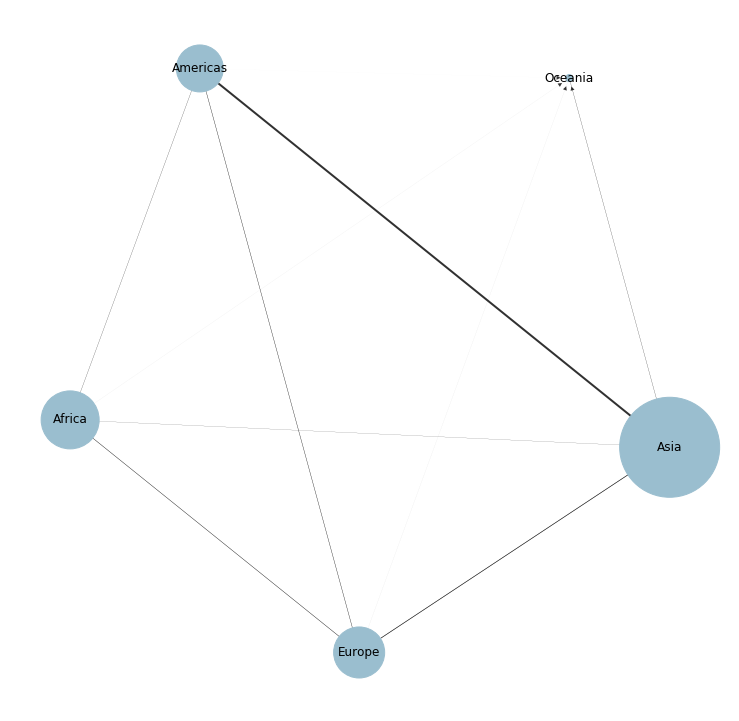

In [34]:
nx_continent_weighted = region_continent_weighted_pipeline(continents, continent_names, "2015", df_pop_continent, df_trade_continent_weighted, directed=True)

In [35]:
nx_continent_weighted.nodes()

NodeView(('Africa', 'Americas', 'Asia', 'Europe', 'Oceania'))

# 3. Item analysis

## 3.1 Quinoa

In [36]:
df_trade_quinoa_weighted = df_trade.copy()
df_trade_quinoa_weighted = df_trade_quinoa_weighted[df_trade_quinoa_weighted['Item'] == 'Quinoa'].groupby(['Exporter', 'Importer'])\
                                                                             .sum().reset_index()

In [37]:
df_trade_quinoa_weighted

,Exporter,Importer,1993,1994,1995,1996,1997,1998,1999,2000,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Argentina,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Argentina,Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,0.0,0.0
2,Argentina,Canada,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Argentina,Chile,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Argentina,Israel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1545,Uruguay,Israel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0
1546,Uruguay,Paraguay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1547,Uruguay,Turkey,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1548,Venezuela (Bolivarian Republic of),Guyana,0.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
year = "2016"
directed = True
df_trade_quinoa_filtered = df_trade_quinoa_weighted[['Exporter', 'Importer', year]]
nx_grouped_weighted = nx.from_pandas_edgelist(df_trade_quinoa_weighted, 'Exporter', 'Importer', \
                                         edge_attr=year, create_using=nx.Graph())

Connected or not connected?

In [50]:
print(nx.is_connected(nx_grouped_weighted))

True


In [51]:
comp = list(nx.connected_components(nx_grouped_weighted))
print('The graph contains', len(comp), 'connected components')

The graph contains 1 connected components


### Centrality measures

**Transitivity**

In [52]:
print('%.4f' %nx.transitivity(nx_grouped_weighted))

0.3797


**Degree**

In [53]:
degrees = dict(nx_grouped_weighted.degree(nx_grouped_weighted.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for country, degree in sorted_degree[:5]:
    print(country, 'is connected to', degree, 'countries')

Peru is connected to 103 countries
France is connected to 97 countries
United States of America is connected to 86 countries
Bolivia (Plurinational State of) is connected to 83 countries
Germany is connected to 72 countries


Text(0.5, 1.0, 'Degree distribution for the Quinoa network in 2015')

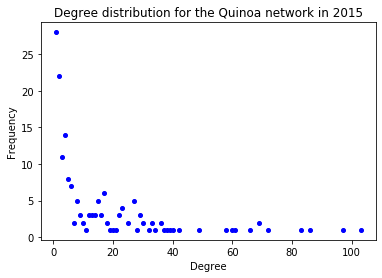

In [54]:
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict(degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quinoa network in 2015')

**Katz Centrality**

In [63]:
degrees = dict(nx_grouped_weighted.degree(nx_grouped_weighted.nodes()))

katz = nx.katz_centrality_numpy(nx_grouped_weighted)
nx.set_node_attributes(nx_grouped_weighted, katz, 'katz')
sorted_katz = sorted(katz.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for country, katzc in sorted_katz[:5]:
    print(country, 'has katz-centrality: %.3f' %katzc)

Russian Federation has katz-centrality: 0.173
Azerbaijan has katz-centrality: 0.108
Georgia has katz-centrality: 0.103
Kyrgyzstan has katz-centrality: 0.101
Tajikistan has katz-centrality: 0.101


**Betweeness centrality**

In [58]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(nx_grouped_weighted)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(nx_grouped_weighted, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for country, bw in sorted_betweenness[:5]:
    print(country, 'has betweeness: %.3f' %bw)

France has betweeness: 0.174
United States of America has betweeness: 0.138
Peru has betweeness: 0.137
Bolivia (Plurinational State of) has betweeness: 0.081
Belgium has betweeness: 0.078


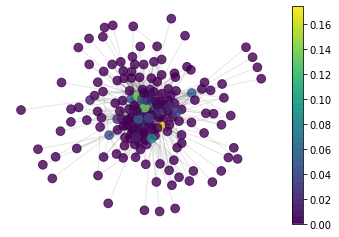

In [60]:
# similar pattern
list_nodes =list(nx_grouped_weighted.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(nx_grouped_weighted)
ec = nx.draw_networkx_edges(nx_grouped_weighted, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(nx_grouped_weighted, pos, nodelist=list_nodes, node_color=[nx_grouped_weighted.nodes[n]["betweenness"] for n in list_nodes], 
                            with_labels=False, alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

In [ ]:
nx.set_node_attributes(G, nx.betweenness_centrality(G), 'betweenness')
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.1, with_labels=True)
nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), with_labels=True,node_color=[G.nodes[n]["betweenness"] for n in G.nodes()], 
                             alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()

## 3.2 Avocados

In [65]:
df_trade_avocado_weighted = df_trade.copy()
df_trade_avocado_weighted = df_trade_avocado_weighted[df_trade_avocado_weighted['Item'] == 'Avocados'].groupby(['Exporter', 'Importer'])\
                                                                             .sum().reset_index()

In [66]:
df_trade_avocado_weighted

,Exporter,Importer,1993,1994,1995,1996,1997,1998,1999,2000,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,Belarus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Afghanistan,Croatia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Afghanistan,France,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Afghanistan,India,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Afghanistan,Mauritius,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3707,Zimbabwe,Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,2.0
3708,Zimbabwe,Ukraine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3709,Zimbabwe,United Arab Emirates,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3710,Zimbabwe,United Kingdom,19.0,0.0,0.0,0.0,11.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0,214.0


In [67]:
year = "2016"
directed = True
df_trade_avocado_weighted = df_trade_avocado_weighted[['Exporter', 'Importer', year]]
nx_grouped_weighted = nx.from_pandas_edgelist(df_trade_avocado_weighted, 'Exporter', 'Importer', \
                                         edge_attr=year, create_using=nx.Graph())

Connected or not connected?

In [68]:
print(nx.is_connected(nx_grouped_weighted))

True


In [69]:
comp = list(nx.connected_components(nx_grouped_weighted))
print('The graph contains', len(comp), 'connected components')

The graph contains 1 connected components


### Centrality measures

**Transitivity**

In [70]:
print('%.4f' %nx.transitivity(nx_grouped_weighted))

0.4429


**Degree**

In [71]:
degrees = dict(nx_grouped_weighted.degree(nx_grouped_weighted.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for country, degree in sorted_degree[:5]:
    print(country, 'is connected to', degree, 'countries')

Netherlands is connected to 141 countries
France is connected to 124 countries
South Africa is connected to 124 countries
United States of America is connected to 112 countries
Spain is connected to 109 countries


Text(0.5, 1.0, 'Degree distribution for the Quinoa network in 2015')

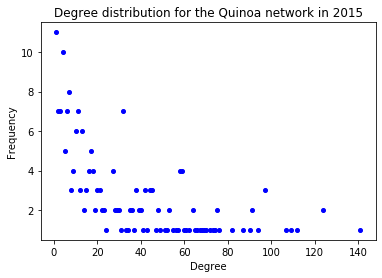

In [72]:
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict(degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the Quinoa network in 2015')

**Katz Centrality**

In [73]:
degrees = dict(nx_grouped_weighted.degree(nx_grouped_weighted.nodes()))

katz = nx.katz_centrality_numpy(nx_grouped_weighted)
nx.set_node_attributes(nx_grouped_weighted, katz, 'katz')
sorted_katz = sorted(katz.items(), key=itemgetter(1), reverse=True)

# And the top 5 most popular quakers are.. 
for country, katzc in sorted_katz[:5]:
    print(country, 'has katz-centrality: %.3f' %katzc)

France has katz-centrality: 0.180
South Africa has katz-centrality: 0.150
Uganda has katz-centrality: 0.149
Zimbabwe has katz-centrality: 0.143
Saint Vincent and the Grenadines has katz-centrality: 0.138


**Betweeness centrality**

In [74]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(nx_grouped_weighted)
# Assign the computed centrality values as a node-attribute in your network
nx.set_node_attributes(nx_grouped_weighted, betweenness, 'betweenness')
sorted_betweenness = sorted(betweenness.items(), key=itemgetter(1), reverse=True)

for country, bw in sorted_betweenness[:5]:
    print(country, 'has betweeness: %.3f' %bw)

Netherlands has betweeness: 0.094
South Africa has betweeness: 0.072
New Zealand has betweeness: 0.070
France has betweeness: 0.068
United States of America has betweeness: 0.050


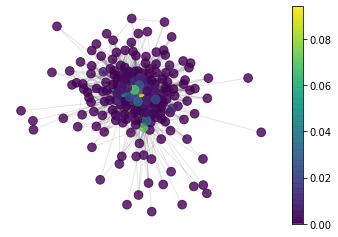

In [75]:
# similar pattern
list_nodes =list(nx_grouped_weighted.nodes())
list_nodes.reverse()   # for showing the nodes with high betweeness centrality 
pos = nx.spring_layout(nx_grouped_weighted)
ec = nx.draw_networkx_edges(nx_grouped_weighted, pos, alpha=0.1)
nc = nx.draw_networkx_nodes(nx_grouped_weighted, pos, nodelist=list_nodes, node_color=[nx_grouped_weighted.nodes[n]["betweenness"] for n in list_nodes], 
                            with_labels=False, alpha=0.8, node_shape = '.')
plt.colorbar(nc)
plt.axis('off')
plt.show()